## Elastic Weights Consolidation(EWC)
xz2830 Xixi Zhou

### Part 1: Preparation

In [1]:
!free -m
!df -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          16045         851       14410           0         783       14919
Swap:             0           0           0
Filesystem        Size  Used Avail Use% Mounted on
overlay           2.0T  1.8T  250G  88% /
tmpfs              64M     0   64M   0% /dev
tmpfs             7.9G     0  7.9G   0% /sys/fs/cgroup
shm               5.5G     0  5.5G   0% /dev/shm
/dev/sda1         122G  5.1G  117G   5% /opt/bin
/dev/loop1        4.9G   21M  4.9G   1% /kaggle/src
/dev/mapper/snap  2.0T  1.8T  250G  88% /etc/hosts
tmpfs             7.9G     0  7.9G   0% /proc/acpi
tmpfs             7.9G     0  7.9G   0% /proc/scsi
tmpfs             7.9G     0  7.9G   0% /sys/firmware


In [2]:
!pip install --upgrade torch torchvision
import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Requirement already up-to-date: torch in /opt/conda/lib/python3.6/site-packages (1.4.0)
Requirement already up-to-date: torchvision in /opt/conda/lib/python3.6/site-packages (0.5.0)
Torch 1.4.0 CUDA 10.1


In [3]:
import torch
torch.cuda.is_available()

True

import libraries we need

In [4]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
from PIL import Image

Import scripts provided from Continual AI Colab repository.   
The train dataset is 60000 , 28x28 grayscale images.

In [5]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 115 (delta 3), reused 8 (delta 1), pack-reused 97
Receiving objects: 100% (115/115), 206.64 KiB | 0 bytes/s, done.
Resolving deltas: 100% (37/37), done.


In [6]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


In [7]:
x_train, t_train, x_test, t_test = mnist.load()
print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


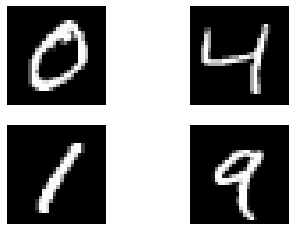

In [8]:
# show the actual images
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

We run this problem in GPU for highly parallelism to improve efficiency of computation.

In [9]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
# switch to run in GPU else in CPU
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

### Part 2：basic model

I compare a new CNN model with a MLP model(change conv-layer all to fully connected).The accuracy of CNN model do a better job than MLP.  
The structure is 2 convolution layer with Conv2d,ReLU and maxPool.And a fully connected layer.

In [10]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout


In [11]:
class CNN(nn.Module): 
  def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layer1 = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2),
            ReLU(inplace = True),
            MaxPool2d(kernel_size = 2, stride = 2))
        self.cnn_layer2 = Sequential(
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2),
            ReLU(inplace = True),
            MaxPool2d(kernel_size = 2, stride = 2))
        self.drop_out = Dropout()
        #fully connected layer
        self.fc1 = Linear(7*7*64,1000) 
        self.fc2 = Linear(1000,10)
        

  # Defining the forward pass    
  def forward(self, x):
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        # flatten image input
        x = x.view(x.size(0),-1)
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [12]:
class full_Net(nn.Module):
    def __init__(self):
        super(full_Net,self).__init__()
        #4 hidden layer
        # linear layer (784 -> hidden_1)
        self.fc1 = Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = Linear(512,256)
        self.fc3 = Linear(256 ,128)
        # linear layer (n_hidden -> 10)
        self.fc4 = Linear(128,10)
        # dropout prevents overfitting of data
        # dropout layer (p=0.2)
        self.droput = Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(x.size(0),-1)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x)
        x = self.fc4(x)

        return x

In [13]:
def train(model, device, x_train, t_train, optimizer, epoch, batch_size):
    model.train()
    
    for start in range(0, len(t_train)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
    
      #set gradients to zero to backpropagation
      optimizer.zero_grad()
    
      output = model(x)
      loss = F.cross_entropy(output, y)
      # adjust weights to minimize loss
      loss.backward()
      optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test, batch_size):
    #notify layers in eval mode
    model.eval()
    test_loss = 0
    correct = 0
    #to sampling data with batch size
    for start in range(0, len(t_test)-1, batch_size):
      end = start + batch_size
      # impacts autograd engine and deactive
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        
        output = model(x)
        # loss accumulation
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

![](https://shaoanlu.files.wordpress.com/2017/05/trn_acc.png)

In [14]:
model = CNN().to(device)
#model = full_Net().to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adadelta(model.parameters())
#optimizer = optim.SGD(model.parameters(),lr=0.01,momentum = 0.9)


In [15]:
batch_size = 256
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch,batch_size)
  test(model, device, x_test, t_test, batch_size)

Train Epoch: 1 	Loss: 0.253308
Test set: Average loss: 0.0001, Accuracy: 9713/10000 (97%)

Train Epoch: 2 	Loss: 0.296768
Test set: Average loss: 0.0000, Accuracy: 9809/10000 (98%)



The accuracy is improve to 97%

### Part 3:Rotate MNIST
We buid a rotate data set to find that same model can't solve new data.

In [16]:
def rotate(data, seed):
    #set seed for generating random numbers.Return a torch.generator object
    torch.manual_seed(seed)
    rotation=torch.rand(1)*360
    result = np.ndarray((data.shape),np.float32)

    for i in range(data.shape[0]):
        img = Image.fromarray(data[i][0])
        result[i][0] = img.rotate(rotation)
    return result

In [17]:
# Rotate MNIST dataset 
x_train2 = rotate(x_train, 1)
x_test2 = rotate(x_test, 1)

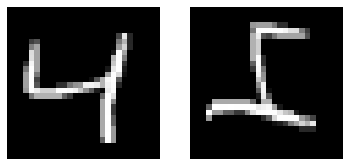

In [18]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[2, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

It shows we train model base on x_test.The model works bad in rotated dataset.The acc is only 24%.

In [19]:
print("Testing on the first task:")
test(model, device, x_test, t_test,batch_size)

print("Testing on the second task:")
test(model, device, x_test2, t_test,batch_size);

Testing on the first task:
Test set: Average loss: 0.0000, Accuracy: 9809/10000 (98%)

Testing on the second task:
Test set: Average loss: 0.0030, Accuracy: 1437/10000 (14%)



And train model base on x_test2,it also works bad on x_test.The acc is only 15%.

In [20]:
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch, batch_size)
  test(model, device, x_test2, t_test, batch_size)
print("Testing on the first task:")
test(model, device, x_test, t_test, batch_size);
print("Testing on the second task:")
test(model, device, x_test2, t_test, batch_size)

Train Epoch: 1 	Loss: 0.354399
Test set: Average loss: 0.0000, Accuracy: 9813/10000 (98%)

Train Epoch: 2 	Loss: 0.211645
Test set: Average loss: 0.0000, Accuracy: 9877/10000 (99%)

Testing on the first task:
Test set: Average loss: 0.0016, Accuracy: 4362/10000 (44%)

Testing on the second task:
Test set: Average loss: 0.0000, Accuracy: 9877/10000 (99%)



98.77

### Part 4: CL strategy
This is Catasrophic Forgetting.So the solution is to learning conotinuously which called Continual learning.  
In this part,I build function to build tasks for rotated MNIST.

In [21]:
def tasks_build(num):
  task_1 = [(x_train, t_train), (x_test, t_test)]
  tasks=[]
  tasks.append(task_1)
  x_trainN=x_train
  x_testN=x_test
  for i in range(1,num):
    x_trainN = rotate(x_trainN, i)
    x_testN = rotate(x_testN, i)
    taskN=[(x_trainN, t_train), (x_testN, t_test)]
    tasks.append(taskN)
  return tasks

In [22]:
tasks_num=10
tasks=tasks_build(tasks_num)

check rotation.

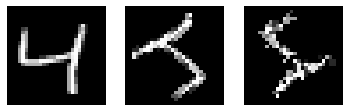

In [23]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x_train[2, 0], cmap="gray")
(x_train_2,t_train),_=tasks[2]
(x_train_3,t_train),_=tasks[7]
axarr[1].imshow(x_train_2[2, 0], cmap="gray")
axarr[2].imshow(x_train_3[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

#### Elastic weights Consolidation(EWC)
Suppose there are two tasks A and B.EWC is to make model learn tasks A.Then learn task B without using data of Task A.   
<img src="https://miro.medium.com/max/1400/1*WSvBc-3vA2D0I26ewMxw7A.png" width="400">

Fisher matrix represent the parameter Theta k's importance of last task.

λ is how important the old task A compare to the new one task B.

In [24]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4


In [25]:
#model = CNN().to(device)
model = full_Net().to(device)
optimizer = optim.Adadelta(model.parameters())
#optimizer = optim.SGD(model.parameters(),lr=0.01,momentum = 0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

EWC formula from:[Elastic Weights Consolidation](https://arxiv.org/abs/1612.00796)
![formula](https://miro.medium.com/max/1076/1*tON3f3xLkaFswgOOzuUqng.png)

In [26]:
def on_task_update(task_id, x_mem, t_mem,batch_size):

  model.train()
  optimizer.zero_grad()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients
  for start in range(0, len(t_mem)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      # cross_entropy for loss
      loss = F.cross_entropy(output, y)
      # gradient decents dloss/dx---> x.grad+=dloss/dx
      # ∂L(d,Theta)/Theta,d is the input data
      loss.backward()

  # calculate fisher and optimize
  for name, param in model.named_parameters():
    #find optimized
    optpar_dict[task_id][name] = param.data.clone()
    #fisher matrix 
    #F=∂^2L(d,Theta)/∂Theta_i∂Theta_j
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

In [27]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch,ewc_lambda,batch_size):
    
    model.train()

    for start in range(0, len(t_train)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      # clear x.grad for every x in oprimizer
      optimizer.zero_grad()

      output = model(x)
      # LB(Theta)=Lcross(y_hat,t=y_hat_1),loss for taskB only
      loss = F.cross_entropy(output, y)
      
      # loss function computation
      for task in range(task_id):
        for name, param in model.named_parameters():
          # Fisher information matrix Fi
          fisher = fisher_dict[task][name]
          # Theta *k,optimal weight values from first task
          optpar = optpar_dict[task][name]
          # param is Theta k, LA=SUM(F*(Theta*k-Theta k)^2)*λ/2
          # Loss=LA+LB
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      # gradient decents dloss/dx---> x.grad+=dloss/dx
      loss.backward()
      # x+=-lr * x.grad
      optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

run and train.

I try to use CNN as basic model,but it don't work well only less than 60%.Then I change to net model all fully-connected.It works much more better than CNN.

In [28]:
ewc_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  for epoch in range(1, 10):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch,ewc_lambda,batch_size)
  on_task_update(id, x_train, t_train,batch_size)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test,batch_size)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / tasks_num)
  ewc_accs.append(avg_acc / tasks_num)

Training on task:  0
Train Epoch: 1 	Loss: 0.242995
Train Epoch: 2 	Loss: 0.330761
Train Epoch: 3 	Loss: 0.166715
Train Epoch: 4 	Loss: 0.146505
Train Epoch: 5 	Loss: 0.124541
Train Epoch: 6 	Loss: 0.118038
Train Epoch: 7 	Loss: 0.077014
Train Epoch: 8 	Loss: 0.091735
Train Epoch: 9 	Loss: 0.073542
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9769/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0052, Accuracy: 1429/10000 (14%)

Testing on task:  2
Test set: Average loss: 0.0053, Accuracy: 1914/10000 (19%)

Testing on task:  3
Test set: Average loss: 0.0053, Accuracy: 1930/10000 (19%)

Testing on task:  4
Test set: Average loss: 0.0012, Accuracy: 7041/10000 (70%)

Testing on task:  5
Test set: Average loss: 0.0051, Accuracy: 1438/10000 (14%)

Testing on task:  6
Test set: Average loss: 0.0053, Accuracy: 1391/10000 (14%)

Testing on task:  7
Test set: Average loss: 0.0040, Accuracy: 2714/10000 (27%)

Testing on task:  8
Test set: Average loss: 0.0050, Accuracy

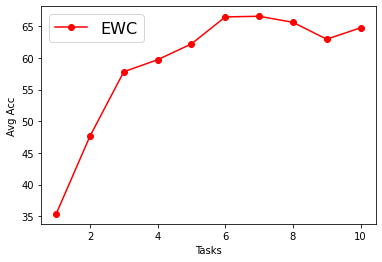

In [29]:
fig, ax = plt.subplots()
x=np.arange(1,tasks_num+1)
plt.plot(x, ewc_accs, '-o', label="EWC", color = 'r')
plt.xlabel('Tasks', fontsize=10)
plt.ylabel('Avg Acc', fontsize=10)
plt.legend(prop={'size': 16});

In [30]:
lam_list =[] 
for i in range(10,55,5):
    lam_list.append(i/100)
print(lam_list)
lam_acc =[]

for lambda_i in lam_list: 
    print("current lambda: ", lambda_i)
    lam_diff_ewc_acc = []
    model = CNN().to(device)
    optimizer = optim.Adadelta(model.parameters())
    for id, task in enumerate(tasks[:3]):
        avg_acc = 0
        print("Training on task: ", id)

        (x_train, t_train), _ = task

        for epoch in range(1, 3):
          train_ewc(model, device, id, x_train, t_train, optimizer, epoch,lambda_i,batch_size)
        on_task_update(id, x_train, t_train,batch_size)

        for id_test, task in enumerate(tasks[:3]):
            print("Testing on task: ", id_test)
            _, (x_test, t_test) = task
            acc = test(model, device, x_test, t_test,batch_size)
            avg_acc = avg_acc + acc

        print("Avg acc: ", avg_acc / 3)
        lam_diff_ewc_acc.append(avg_acc / 3)
    lam_acc.append(lam_diff_ewc_acc)

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
current lambda:  0.1
Training on task:  0
Train Epoch: 1 	Loss: 0.384670
Train Epoch: 2 	Loss: 0.313166
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9636/10000 (96%)

Testing on task:  1
Test set: Average loss: 0.0033, Accuracy: 1385/10000 (14%)

Testing on task:  2
Test set: Average loss: 0.0036, Accuracy: 2332/10000 (23%)

Avg acc:  44.51
Training on task:  1
Train Epoch: 1 	Loss: 0.443729
Train Epoch: 2 	Loss: 0.260078
Testing on task:  0
Test set: Average loss: 0.0012, Accuracy: 5332/10000 (53%)

Testing on task:  1
Test set: Average loss: 0.0001, Accuracy: 9677/10000 (97%)

Testing on task:  2
Test set: Average loss: 0.0034, Accuracy: 3277/10000 (33%)

Avg acc:  60.95333333333334
Training on task:  2
Train Epoch: 1 	Loss: 0.336871
Train Epoch: 2 	Loss: 0.412756
Testing on task:  0
Test set: Average loss: 0.0019, Accuracy: 4535/10000 (45%)

Testing on task:  1
Test set: Average loss: 0.0016, Accuracy: 5853/10000 (59

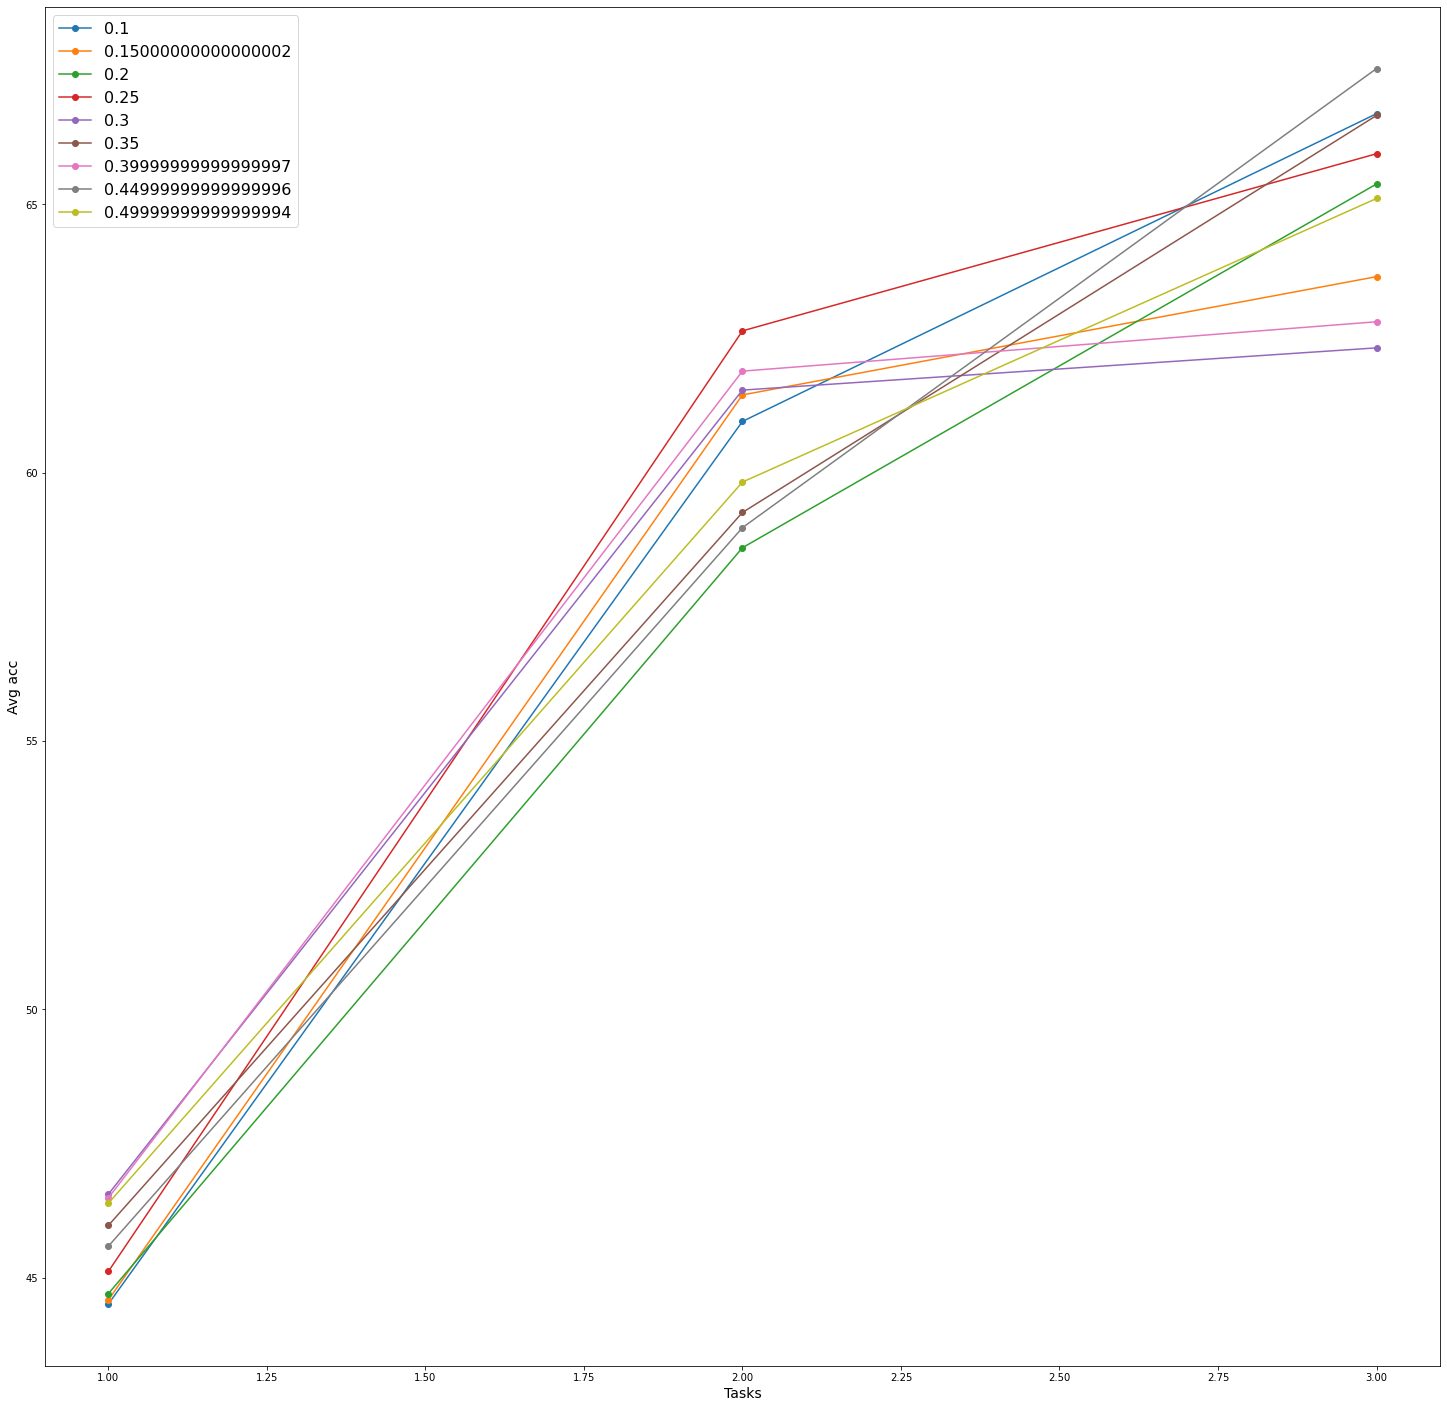

In [31]:
fig, ax = plt.subplots(figsize=(25,25))
n = 0.1
for i in lam_acc: 
    x=np.arange(1,4)
    plt.plot(x,i, '-o', label= n)
    plt.xlabel('Tasks', fontsize=14)
    plt.ylabel('Avg acc', fontsize=14)
    n += 0.05
    plt.legend(prop={'size': 16})